In [1]:
import os
import torch
import librosa
import librosa.display
import scipy
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
speach_path = "../../dataset/en/clips"
noice_path = "../../dataset/noise_dataset/audio/fold4"

noise_filename = '344-3-4-0.wav'
speach_filename = 'common_voice_en_21280403.mp3'

fs = 16e3 # Hz sampling frequency
windowLength = 256
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75%
window = scipy.signal.hamming(windowLength, sym=False)
numSegments = 8
numFeatures = fftLength // 2 + 1

device=torch.device("cuda")

In [3]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr

def remove_silent_frames(audio, filename):
    
    array_sum = np.sum(audio)
    array_has_nan = np.isnan(array_sum)
    
    if array_has_nan:
        print("NNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNNNNN", filename)
    
    trimed_audio = []
    indices = librosa.effects.split(audio, hop_length = overlap, top_db=20)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)


def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power) * noise_segment
    return noisy_audio

def revert_stft_to_audio(stft_spectrogram, phase=None, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    
    #if cleanMean and cleanStd:
    #    features = cleanStd * features + cleanMean

    #phase = np.transpose(phase, (1, 0))
    #features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    #features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    #features = np.transpose(features, (1, 0))
        
    return librosa.istft(stft_spectrogram, win_length=windowLength, hop_length=overlap, window=window, center=True)

def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [4]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)
    
class PrintShape(nn.Module):
    def __init__(self,i):
        super().__init__()
        self.i=i
    def forward(self, x):
        print("PrintShape: stage:",self.i,"shape",x.shape)
        return x
    
class SaveConnection(nn.Module):
    def __init__(self,i):
        super().__init__()
        #print("lista sad init:",saved_connections)
        self.i=i
        #if i==0:
        #    saved_connections=[]
        if self.i==len(saved_connections):
            saved_connections.append(-1)
        else:
            print("dodaje se konekcija na lose mesto: i,len:",i,len(saved_connections))
    def forward(self, x):
        saved_connections[self.i]=x
        return x

class AddConnection(nn.Module):
    def __init__(self,index):
        super().__init__()
        self.index=index
    def forward(self,x):
        return saved_connections[self.index]+x    
    
saved_connections=[]

model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, 129, 8)),
    #PrintShape(0),

    nn.Conv2d(1, 18, kernel_size=(9,8), padding = 4, bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),
    #PrintShape(10),

    nn.Conv2d(18, 30, kernel_size=(1, 5), padding = (0, 2), bias = False),
    SaveConnection(0),
    nn.ReLU(),
    nn.BatchNorm2d(30),
    #PrintShape(11),

    nn.Conv2d(30, 8, kernel_size=(1, 9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(1),
    # -- 1

    nn.Conv2d(8, 18, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(1,5), padding = (0, 2), bias = False),
    SaveConnection(1),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(2),
    # -- 2   
    
    nn.Conv2d(8, 18, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(1,5), padding = (0, 2), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(3),
    # -- 3

    nn.Conv2d(8, 18, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(1,5), padding = (0, 2), bias = False),
    AddConnection(1),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(4),
    # -- 4 

    nn.Conv2d(8, 18, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(1,5), padding = (0, 2), bias = False),
    AddConnection(0),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(1,9), padding = (0, 4), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(5),
    # -- 5
    
    nn.Dropout(p=0.2),
    nn.Conv2d(8, 1, kernel_size=(1,9), padding = 0)

)


model


Sequential(
  (0): Lambda()
  (1): Conv2d(1, 18, kernel_size=(9, 8), stride=(1, 1), padding=(4, 4), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(18, 30, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
  (5): SaveConnection()
  (6): ReLU()
  (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(30, 8, kernel_size=(1, 9), stride=(1, 1), padding=(0, 4), bias=False)
  (9): ReLU()
  (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(8, 18, kernel_size=(1, 9), stride=(1, 1), padding=(0, 4), bias=False)
  (12): ReLU()
  (13): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(18, 30, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
  (15): SaveConnection()
  (16): ReLU()
  (17): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [5]:
PATH = "../../model/model2.pth"

model.load_state_dict(torch.load(PATH))

model.cuda()

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 18, kernel_size=(9, 8), stride=(1, 1), padding=(4, 4), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(18, 30, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
  (5): SaveConnection()
  (6): ReLU()
  (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(30, 8, kernel_size=(1, 9), stride=(1, 1), padding=(0, 4), bias=False)
  (9): ReLU()
  (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(8, 18, kernel_size=(1, 9), stride=(1, 1), padding=(0, 4), bias=False)
  (12): ReLU()
  (13): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(18, 30, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
  (15): SaveConnection()
  (16): ReLU()
  (17): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [6]:
clean_audio, sampl_rate_clean = read_audio(os.path.join(speach_path, speach_filename), sample_rate=fs)

noice_audio, sampl_rate_noice = read_audio(os.path.join(noice_path, noise_filename), sample_rate=fs)


clean_audio = remove_silent_frames(clean_audio, "")
noice_audio = remove_silent_frames(noice_audio, "")

#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

#ax1.plot(clean_audio)
#ax1.set_title("Clean Audio")

#ax2.plot(noice_audio)
#ax2.set_title("Noice Audio")

#print("Min:", np.min(clean_audio),"Max:",np.max(clean_audio))


C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


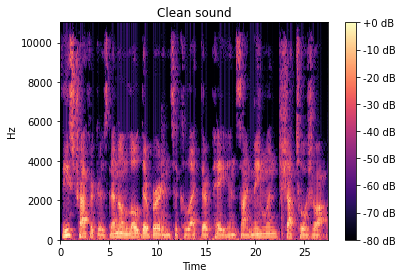

In [7]:
clean_audio_stft = librosa.stft(clean_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
clean_audio_stft_abs = np.abs(clean_audio_stft)
clean_audio_stft_abs_db = librosa.amplitude_to_db(clean_audio_stft_abs,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(clean_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Clean sound')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=clean_audio, rate=sampl_rate_clean) # load a local WAV file

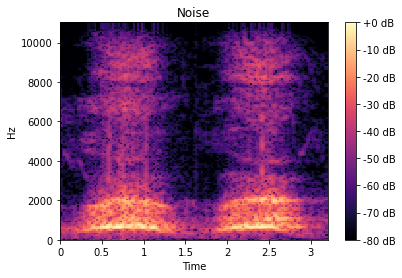

In [8]:
noice_audio_stft = librosa.stft(noice_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noice_audio_stft_abs = np.abs(noice_audio_stft)
noice_audio_stft_abs_db = librosa.amplitude_to_db(noice_audio_stft_abs,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(noice_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Noise')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=noice_audio, rate=sampl_rate_noice) # load a local WAV file

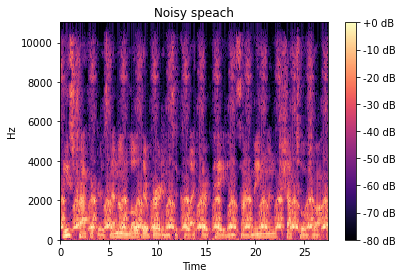

In [9]:
noice_and_audio = add_noise_to_clean_audio(clean_audio, noice_audio)

noice_and_audio_stft = librosa.stft(noice_and_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noice_and_audio_stft_abs = np.abs(noice_and_audio_stft)
noice_and_audio_stft_abs_db = librosa.amplitude_to_db(noice_and_audio_stft_abs, ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(noice_and_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Noisy speach')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=noice_and_audio, rate=sampl_rate_clean) 

In [10]:
noise_and_speach_chunks = prepare_input_features(noice_and_audio_stft_abs, numSegments, numFeatures)
noise_and_speach_chunks = np.transpose(noise_and_speach_chunks, (2, 0, 1))
#print(noise_and_speach_chunks.shape)

noise_and_speach_chunks = noise_and_speach_chunks.astype(np.float32)
noise_and_speach_chunks = torch.from_numpy(noise_and_speach_chunks)

#print(noise_and_speach_chunks)

In [11]:
spectrogram_stft = [] 

#print(len(noise_and_speach_chunks))

for inp in noise_and_speach_chunks:
    x = inp.cuda()
    y = model(x).cpu()
#    print(y[0,0].detach().numpy().shape)
    
    spectrogram_stft.append(y[0,0].detach().numpy())
    
spectrogram_stft = np.array(spectrogram_stft)
spectrogram_stft = np.squeeze(spectrogram_stft)
spectrogram_stft = np.transpose(spectrogram_stft, (1, 0))

#print(spectrogram_stft.shape)

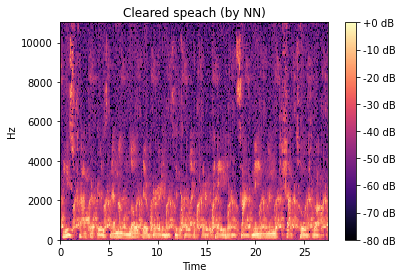

In [12]:
spectrogram_stft_db = librosa.amplitude_to_db(spectrogram_stft,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(spectrogram_stft_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Cleared speach (by NN)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

denoised_audio = revert_stft_to_audio(spectrogram_stft)
play(denoised_audio, fs)
